In [5]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML

def css_styling():
    styles = """
<style>
.output_png { text-align:  center; }
</style>
    """
    return HTML(styles)
css_styling()

import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
def runMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def safeSigmoid(x, eps=0.0):
    y = 1.0/(1.0 + np.exp(-x))
    # przytnij od dolu i gory
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    return -np.sum(np.multiply(y, np.log(f)) + 
                   np.multiply(1 - y, np.log(1 - f)), axis=0)/m

def dJ(h,theta,X,y):
    return 1.0/len(y)*(X.T*(h(theta,X)-y))

def softmax(X):
    X128 = X.astype(np.float128)
    return np.exp(X128)/np.sum(np.exp(X128))

## Wykład 07

# Metody optymalizacji

* Warianty algorytmu GD*
* Metody zbiorcze
* Urozmaicenie metod

# Déjà vu: Gradient Descent i regresja logistyczna

## Regresja logistyczna - model

Model regresji logistycznej:

$$h_\theta(X) = g(X\theta) = \dfrac{1}{1+e^{-X\theta}}$$


## Regresja logistyczna - Funkcja kosztu

Funkcja kosztu dla regresji logistycznej:
$$\small
J(\theta) = -\dfrac{1}{m} [\sum_{i=1}^{m} y^{(i)} \log h_\theta(x^{(i)})+ (1-y^{(i)}) \log (1-h_\theta(x^{(i)}))]$$

Gradient funkcji kosztu:

$$\nabla J(\theta) = \frac{1}{|\vec y|} X^T\left(h_\theta(X)-\vec y\right)$$

## (Batch) Gradient descent 


W postaci wektorwej:

$$ \theta_{t+1} = \theta_{t} - \alpha \nabla J(\theta_{t}) $$

lub iteracyjnej:

$$
\begin{array}{rcll}
\theta_{t+1,j} & := & \theta_{t,j} - \alpha \dfrac{\partial}{\partial\theta_{t,j}}J(\theta_t) & \;j=0,\ldots,n\\ 
\end{array}
$$



## Dla regresji logistycznej

Wykonaj określoną liczbę razy:

$$\small
\begin{array}{rcll}\small
\theta_{t+1,j} & := & \theta_{t,j} - \alpha \dfrac{1}{m}\displaystyle\sum_{i=1}^m (h_{\theta_{t,j}}(x^{(i)})-y^{(i)})x^{(i)}& j=0,\ldots,n\\ \\ 
\end{array}
$$

## Część 1.
# Warianty algorytmu Gradient Descent

**Gradient descent:**

* Powtórz określoną liczbę razy (liczba epok):
$$
\begin{equation}
\theta_{t+1,j} := \theta_{t,j} - \alpha \dfrac{1}{m}\displaystyle\sum_{i=1}^m (h_{\theta_{t,j}}(x^{(i)})-y^{(i)})x^{(i)}\\ 
(\textrm{dla } j=0,\ldots,n)\\
\end{equation}
$$

_Epoka_ to jednokrotne przejście przez wszystkie dane uczące.

**Stochastic Gradient Descent:**

* Randomizuj dane treningowe
* Powtórz określoną liczbę razy (liczba epok):
  * Powtórz dla każdego $i=1,\dots,m$:
$$
\begin{equation}
\theta_{t+1,j} := \theta_{t,j} - \alpha (h_{\theta_{t,j}}(x^{(i)})-y^{(i)})x^{(i)} \\
(\textrm{dla } j=0,\ldots,n)\\
\end{equation}
$$

_Randomizacja danych_ to losowe potasowanie przykładów uczących (wspólnie z odpowiedziami). 

#### Dyskusja:

* Ile uaktualnień parametru $\theta$ wykonuje algorytm SGD podczas jednej epoki? 
* Ile uaktualnień wykonuje algorytm (Batch) GD?
* Co daje randomizacja danych w przypadku SGD?
* Czy randomizacja może pomóc w GD?

**Mini-Batch Gradient Descent:**

* Ustal rozmiar wsadu ("batch") $b \le m$ 
* Randomizuj dane treningowe
* Powtórz określoną liczbę razy (liczba epok):
  * Powtórz dla każdego $i=1,1+b,1+2b,\dots,m-b+1$:
$$
\begin{equation}
\theta_{t+1,j} := \theta_{t,j} - \alpha \dfrac{1}{b} \displaystyle\sum_{k=i}^{i+b-1} (h_{\theta_{t,j}}(x^{(k)})-y^{(k)})x^{(k)} \\
(\textrm{dla } j=0,\ldots,n)\\
\end{equation}
$$

Typowe wartości dla $b$ to od kilku przykładów do kilkuset, tj. małe w porównaniu do $m$. 

### Dyskusja:

* Znając $m$ i $b$, ile razy zostanie uaktualniony parametr $\theta$?
* Jak mają się SGD oraz GD do Mini-Batch SGD?

## Mini-Batch SGD - implementacja

In [7]:
def MiniBatchSGD(h, fJ, fdJ, theta, X, y, 
        alpha=0.001, maxEpochs=1.0, batchSize=100, 
        logError=True):
    errorsX, errorsY = [], []
    
    m, n = X.shape
    start, end = 0, batchSize
    
    maxSteps = (m * float(maxEpochs)) / batchSize
    for i in range(int(maxSteps)):
        XBatch, yBatch =  X[start:end,:], y[start:end,:]

        theta = theta - alpha * fdJ(h, theta, XBatch, yBatch)
        
        if logError:
            errorsX.append(float(i*batchSize)/m)
            errorsY.append(fJ(h, theta, XBatch, yBatch).item())
        
        if start + batchSize < m:
            start += batchSize
        else:
            start = 0
        end = min(start + batchSize, m)
        
    return theta, (errorsX, errorsY)

## Porównanie GD, SGD, Mini-Batch SGD 

Na przykładzie MNIST

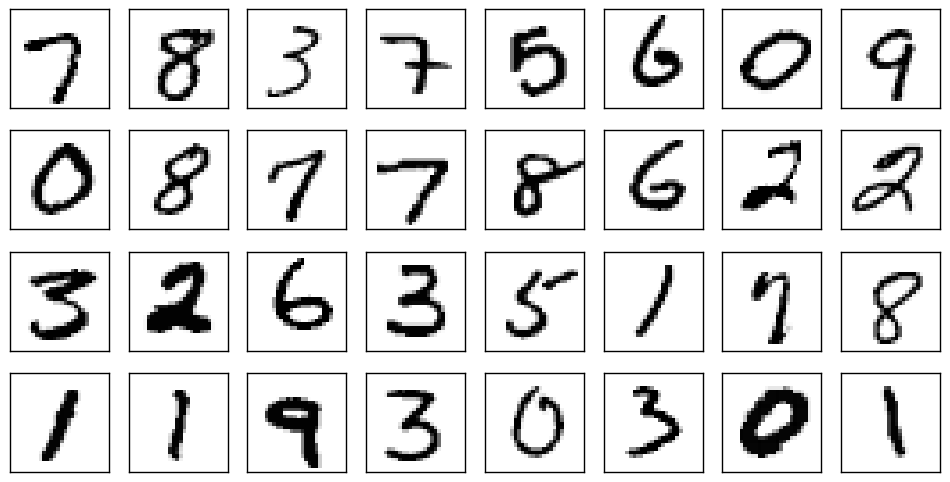

In [8]:
import os
import struct
import numpy as np
from matplotlib import pyplot
import matplotlib as mpl

np.seterr(over="ignore")
%matplotlib inline

def readMnist(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise(ValueError, "dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def showImage(image, r=1, c=1, i=1, fig=None):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    if fig is None:
        fig = pyplot.figure()
    ax = fig.add_subplot(r,c,i)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    if fig is None:
        ax.xaxis.set_ticks_position('top')
        ax.yaxis.set_ticks_position('left')
        pyplot.show()    
    
def showImageGrid(data, r, c):
    fig = pyplot.figure(figsize=(c*1.5,r*1.5))
    for i,row in enumerate(data[:r*c]):
        image = row[:, 1:].reshape(28,28)
        showImage(image, r, c, i+1, fig)
    pyplot.show()

    
def toMatrix(data, maxItems=60000):
    datalist = [t for t in data]
    np.random.shuffle(datalist) # randomizacja danych
    m = len(datalist)
    n = 28 * 28 + 1
    X = np.matrix(np.zeros(m * n)).reshape(m, n)
    Y = np.matrix(np.zeros(m)).reshape(m, 1)
    for i, (label, image) in enumerate(datalist[:maxItems]):
        X[i, 0] = 1 # bias term
        X[i, 1:] = image.reshape(28*28,)
        Y[i] = label
    return X, Y

def mapY(y, cls):
    m = len(y)
    yBi = np.matrix(np.zeros(m)).reshape(m, 1)
    yBi[y == cls] = 1.
    return yBi

def indicatorMatrix(y):
    classes = np.unique(y.tolist())
    m = len(y)
    k = len(classes)
    Y = np.matrix(np.zeros((m, k)))
    for i, cls in enumerate(classes):
        Y[:,i] = mapY(y, cls)
    return Y

dataDir = "../../labs/06"

mnistTrain = readMnist("training", path=dataDir)
mnistTest = readMnist("testing", path=dataDir)

XTrain, YTrain = toMatrix(mnistTrain)
XTest, YTest = toMatrix(mnistTest)

YTrain = indicatorMatrix(YTrain)
YTest = indicatorMatrix(YTest)

k = YTest.shape[1]

showImageGrid(XTrain, 4, 8)

## Krzywe uczenia <br/>dla binarnej regresji logistycznej
### (liczba 8)

<img src="sgd1.png" />

## Uśrednione krzywe uczenia <br/>dla binarnej regresji logistycznej
#### (liczba 8)

<img src="sgd2.png" />

### SGD vs GD

* SGD jest znacznie szybszy i często daje lepsze wyniki
* Warianty SGD, gdzie $b \ll m$ (znacząco mniejsze) nazywa się też algorytmami **on-line**
* Dane uczące są bardzo duże, a nawet nieograniczone (*uczenie on-line*)

### Dyskusja 
* Czy SGD można przerwać i wznowić? Jeśli tak, kiedy?
* O co trzeba zadbać? Co trzeba zapisać?
* W najgorszym przypadku, ile informacji stracimy?
* Czy można wykorzystać częsciowe wyniki?


## Google: Downpour SGD (J. Dean ***et al.***)
<br/>
<img src="downpour.png" width="85%"/>

## Inne warianty SGD:

* Nesterov accelerated gradient (Nesterov, 1983)
* SGD with Momentum (Rumelhart *et al.*, 1986)
* AdaGrad (Duchi *et al.*, 2011)
* Downpour SGD (Dean *et al.*, 2012)
* AdaDelta (Google, Zeiler *et al.*, 2012)
* RMSprop (Hinton *et al.*, 2012)
* v-SGD-{l,g,b} (LeCunn *et al.*, 2012)
* Adam (Kingma & Ba, 2015)
* ...

Od tej pory algorytm GD będziemy traktowali jako wariant SGD.

# AdaGrad

J. Duchi *et al.* (2011), *Adaptive Subgradient Methods for Online Learning and Stochastic Optimization*. Journal of Machine Learning Research 12. pp. 2121-2159

## Problemy z naiwnymi metodami SGD

* Trudno dobrać rozmiar kroku $\alpha$
* Po zmianie innych parametrów, np. rozmiaru wsadu lub liczby epok, trzeba często na nowo dostroić $\alpha$
* SGD nie radzi sobie zbyt dobrze z cechami nieznormalizowanymi

**Dwa usprawnienia**:

1. Różne wartości $\alpha$ w trakcie uczenia
1. Osobne $\alpha$ dla każdego parametru

**SGD** (dowolny wariant) ma jeden stały parametr $\alpha$.

Niech $\mathbf{g}_t = \nabla J(\mathbf{\theta}_t)$, czyli $g_{t,j} = \dfrac{\partial}{\partial\theta_{t,j}}J(\theta_t)$, wtedy SGD ma postać:

$$
\begin{equation}
\theta_{t+1} := \theta_{t} - \alpha \mathbf{g}_t \\
\end{equation}
$$

W ** AdaGrad ** zastępujemy skalar $\alpha$ samostrojącymi się krokami $\alpha_{t,j}$ dla każdej cechy $x_j$ i każdej iteracji $t$:

$$\alpha_{t,j} = \dfrac{\alpha}{\sqrt{\sum_{t^{\prime}=1}^tg_{t^{\prime},j}^2}}$$

gdzie $\sum_{t^{\prime}=1}^tg_{t^{\prime},j}^2$ jest sumą kwadratów wszystkich dotychczasowych gradientów (gradienty historyczne).

Oznaczmy

$$G_t^{-\frac{1}{2}} = \frac{1}{\sqrt{\sum_{t^{\prime}=1}^tg_{t^{\prime},j}^2}},$$
wtedy
$$
\theta_{t+1} = \theta_t - \alpha G_t^{-\frac{1}{2}}\odot \mathbf{g}_t,
$$

gdzie $\odot$ to mnożenie elementowe.

## Intuicja

Rzadkie cechy są nośnikami ważnych informacji (i odwrotnie: cecha, która występuje zawsze, mało wnosi).

Np. MNIST: piksel, który jest bardzo często czarny, nie pomaga rozstrzygnąć, jaką widzimy liczbę:
<img src="mean-mnist-img.png" />

## AdaGrad

* AdaGrad przydziela częstym cechom wysokie wagi (czyli małe kroki $\alpha_{t,j}$) i odwrotnie.
* Występująca cecha ma niezerowy gradient, zatem sumując kw. gradientów, zliczamy cechy.
* Wysokie $\alpha_{t,j}$ w chwili wystąpienia cechy $x_j$ oznacza "Zauważ mnie!".
* Możemy ustawić $\alpha = 1.0$ dla dowolnego problemu.

## AdaGrad - implementacja (przedstawiona na wykładzie)

In [9]:
# Uwaga! To nie jest kompletna funkcja!

def SGD(h, fJ, fdJ, theta, X, y, 
        alpha=0.001, maxEpochs=1.0, batchSize=100, 
        adaGrad=False, logError=False):
    m, n = X.shape
    start, end = 0, batchSize
    
    maxSteps = (m * float(maxEpochs)) / batchSize
    for i in range(int(maxSteps)):
        XBatch, yBatch =  X[start:end,:], y[start:end,:]

        theta = theta - fdJ(h, theta, XBatch, yBatch)
        
        if start + batchSize < m:
            start += batchSize
        else:
            start = 0
        end = min(start + batchSize, m)
        
    return theta

## Test na MNIST 

Ponownie binarny klasyfikator dla cyfry 8

<img src="adagrad.png" />

## Jakość klasyfikacji na zbiorze testowym

In [14]:
def classify(thetas, X):
    regs = np.array([(X*theta).item() for theta in thetas])
    probs = softmax(regs)
    return np.argmax(probs), probs

def accuracy(models, XTest, YTest, k=10):
    acc = [0 for i in range(len(models))]
    cls = [0 for i in range(len(models))]

    YTestCls = YTest * np.matrix((np.arange(k))).T
    for i in range(len(YTestCls)):
        for j, model in enumerate(models):
            cls[j], probs = classify(model, XTest[i])
        correct = int(YTestCls[i].item())
    
        for j in range(len(cls)):
            acc[j] += correct == cls[j]
        
    n = len(XTest)
    return [a / float(n) for a in acc]

def trainLogReg(X, Y, **kwargs):
    n = X.shape[1]
    print(kwargs)
    thetas = []
    for c in range(Y.shape[1]):
        YBi = Y[:,c]
        theta = np.matrix(np.random.random(n)).reshape(n,1)
        thetaBest = SGD(h, J, dJ, theta, 
                        X, YBi, 
                        **kwargs)
        print(".", end="")
        thetas.append(thetaBest)
    print("Done")
    return thetas

In [15]:
epochs = 10
batchSize = 1000

In [16]:
models = [
    trainLogReg(XTrain, YTrain, alpha=0.1, maxEpochs=epochs, 
                batchSize=batchSize, adaGrad=False),
    trainLogReg(XTrain, YTrain, alpha=0.01, maxEpochs=epochs, 
                batchSize=batchSize, adaGrad=False),
    trainLogReg(XTrain, YTrain, alpha=0.001, maxEpochs=epochs, 
                batchSize=batchSize, adaGrad=False),
    trainLogReg(XTrain, YTrain, alpha=1, maxEpochs=epochs, 
                batchSize=batchSize, adaGrad=True)
]

acc = accuracy(models, XTest, YTest)
for j in range(len(models)):
    print("Acc", j, "=", acc[j])

{'adaGrad': False, 'batchSize': 1000, 'maxEpochs': 10, 'alpha': 0.1}
..........Done
{'adaGrad': False, 'batchSize': 1000, 'maxEpochs': 10, 'alpha': 0.01}
..........Done
{'adaGrad': False, 'batchSize': 1000, 'maxEpochs': 10, 'alpha': 0.001}
..........Done
{'adaGrad': True, 'batchSize': 1000, 'maxEpochs': 10, 'alpha': 1}
..........Done
Acc 0 = 0.8572
Acc 1 = 0.7132
Acc 2 = 0.7692
Acc 3 = 0.7927


## Dlaczego nie korzystamy z AdaGrad zawsze?

* Wyniki badawcze wskazują na to, że często **starannie** dobrane $\alpha$ daje lepsze wyniki na zbiorze testowym
* Można też dynamicznie zmieniać $\alpha$ (np. jeśli błąd się nie zmniejszył przez $n$ iteracji, podziel $\alpha$ przez 2, itp.)
* Praktycy uczenia maszynowego nie lubią braku kontroli

**AdaGrad**: dobry algorytm na dobry początek

## Jaką metodę optymalizacji wybrać?

<div style="text-align:center">
<img src="contours_evaluation_optimizers.gif" style="display:inline-block; width:45%" />
<img src="saddle_point_evaluation_optimizers.gif" style="display:inline-block; width:50%"/>
</div>

Źródło: http://cs231n.github.io/neural-networks-3/

## Cześć 2.

# Metody zbiorcze

**Metody zbiorcze** (_ensemble methods_) używają wielu modeli uczenia maszynowego w celu uzyskania lepszej skuteczności niż mogłaby być osiągnięta przez każdy z tych modeli osobno.

Dwa "parametry":

1. Dobór modelu
1. Agregacja wyników

## Uśrednianie prawdopodobieństw

Mamy $M=3$ modele, które dla $c=1\dots5$ klas zwróciły prawdopodobieństwa:

* $M_1$: `[0.1, 0.4, 0.5, 0.0, 0.0]`
* $M_2$: `[0.1, 0.6, 0.2, 0.0, 0.1]`
* $M_3$: `[0.1, 0.3, 0.4, 0.0, 0.2]`

Która klasa zostanie wybrana wg średnich prawdopodobieństw dla każdej klasy?

## Uśrednianie prawdopodobieństw z randomizacją

Tj. z przetasowaniem zbioru uczącego przed trenowaniem każdego modelu

## Głosowanie klas
Nie zapominamy o randomizacji.

Mamy $M=3$ modele, które dla $c=1\dots5$ klas zwróciły prawdopodobieństwa:

* $M_1$: `[0.1, 0.4, 0.5, 0.0, 0.0]`
* $M_2$: `[0.1, 0.6, 0.2, 0.0, 0.1]`
* $M_3$: `[0.1, 0.3, 0.4, 0.0, 0.2]`

Która klasa zostanie wybrana wg liczby głosów na każdą z klas?

## BAGGING = Bootstrap AGGregatING 
To samo co głosowanie klas, ale podczas randomizacji wybieramy $m$ przykładów **z powtórzeniami** (bootstrapping).

## Ważony BAGGING

## Ważenie podczas głosowania/uśredniania

* W bagging, losujemy $m$ przykładów z **powtórzeniami**.
* Prawie 40% danych nie jest wykorzystywanych, ponieważ $\lim_{n \rightarrow \infty}\left(1-\frac{1}{n}\right)^n = e^{-1} \approx 0.368 $.
* Te dane można wykorzystać jako **zestaw walidacyjny** i obliczyć **na nim** błąd $J_w(\theta)$.
* Mając $M$ klasyfikatorów, dla $i$-tego klasyfikatora obliczamy $w_i$:

$$ w_i = \dfrac{\exp(-J_w(\theta_i))}{
\sum_{j=1}^M \exp(-J_w(\theta_j))} $$


* Klasyfikacja przez obliczenie **ważonych średnich prawdopodobieństw** (zbiór klas $C$, $y_i$ to odpowiedź $i$-tego klasyfikatora):
$$y = \mathop{\mathrm{argmax}}_{c \in C} \dfrac{w_ip_{c,i}}{\sum_{j=1}^{M} w_j p_{c,j}} $$
gdzie $p_{c,i}$ jest prawdopodobieństwem wyboru klasy $c$ przez $i$-ty klasyfikator.


* Klasyfikacja przez **ważone głosowanie** (zbiór klas $C$, $y_i$ to odpowiedź $i$-tego klasyfikatora):
$$y = \mathop{\mathrm{argmax}}_{c \in C} \sum_{i=1}^M w_i  I(c = y_i) $$
gdzie 
$$I(A) = \left\{\begin{array}{cl}1 & \textrm{gdy zachodzi zdarzenie A}\\ 0 & \textrm{wpp.}\end{array}\right.$$


## Boosting

Idea:

* Budujemy kolejne klasyfikatory, zwiększając istotność tych przykładów trenujących, dla których poprzednie modele radziły sobie **słabiej**.
* Może działać lepiej niż bagging, ale metoda wrażliwa na _przetrenowanie_ (więcej na następnym wykładzie).

Najbardziej popularny algorytm to Adaboost.

## Stacking

Idea: 
* Budujemy $M$ różnych klasyfikatorów.
* Budujemy jeden **meta-klasyfikator** na podstawie wyników tych $M$ klasyfikatorów.

(Jeśli mamy same regresory logistyczne, to jest to **prawie** dwuwarstwowa sieć neuronowa)